# Correct the Bias in the Accelerometer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime
import plot_data
from scipy import signal
from scipy.spatial.transform import Rotation as R
from ahrs.filters import Madgwick
from ahrs.filters import Mahony

import importlib
importlib.reload(fetch_data)
importlib.reload(plot_data)

<module 'plot_data' from '/home/tyler/Documents/Matt3r/IMU_validation/plot_data.py'>

In [2]:
# old data
start_date_str = '2023-05-30'
end_date_str = '2023-06-01'
organization_id = 'hamid'
can_k3y_id = '9ed5b50e'
imu_k3y_id = '78f8031e'

In [16]:
# new data
start_date_str = '2023-06-28'
end_date_str = '2023-06-28'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

Get Data

In [17]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
imu_df, gy_df = fetch_data.get_raw_data(imu_k3y_id, organization_id, start_date_str, end_date_str, time_correction=True)

Define the Orientation Filter Functions

In [18]:
k3y_g = 9.81
S3_K3Y_VEH_ROT_MTX = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])

def calculate_rot_matrix(ac_data, gy_data, filter_params):
    madg_filter = Madgwick(acc=ac_data, gyr=gy_data, Dt=(1/filter_params['SR']), gain=filter_params['gain'],
                        q0=filter_params['init_qua'])
    quaternions = madg_filter.Q
    filter_params['init_qua'] = quaternions[-1,:]
    # converting quaternion from scalar first (AHRS library) to scalar last(SciPy)
    quaternions_scipy = np.roll(quaternions, shift=3, axis=1)
    rot_mtxs = R.from_quat(quaternions_scipy).as_matrix()

    return rot_mtxs

def gravity_compensate(ac_batch, gy_batch, madgwick_params, g=k3y_g):
    rotation_mtxs = calculate_rot_matrix(ac_batch, gy_batch, madgwick_params)
    # Rotation matrix is orthogonal, last colum = last row of the inverse
    gravity_components = g * rotation_mtxs[:,-1,:]
    ac_g_compensated = ac_batch - gravity_components

    return ac_g_compensated

def imu_k3y_to_vehicle(ac_batch_np, gy_batch_np, madgwick_params):
    g_removed_ac_np = gravity_compensate(ac_batch_np[:, 1:], gy_batch_np[:, 1:], madgwick_params, g=k3y_g)
    vehicle_ac = np.matmul(S3_K3Y_VEH_ROT_MTX, g_removed_ac_np.T)
    vehicle_ac_np = np.column_stack((ac_batch_np[:,0], vehicle_ac.T))

    vehicle_gy = np.matmul(S3_K3Y_VEH_ROT_MTX, gy_batch_np[:, 1:].T)
    vehicle_gy_np = np.column_stack((gy_batch_np[:,0], vehicle_gy.T))

    return vehicle_ac_np, vehicle_gy_np

Define the Function to Select a Batch and Perform AHRS

In [19]:
def compute_AHRS(raw_acc_df, raw_gyro_df, event_dict, madgwick_params):
    buffer = 200
    ac_dr_df_list = []
    gy_dr_df_list = []
    for state_num in range(len(event_dict['driving_state'])):
        dr_start_time = event_dict['driving_state'][state_num]['start']
        dr_end_time = event_dict['driving_state'][state_num]['end']

        # get just the data within the driving state
        ac_dr_motion = raw_acc_df[(raw_acc_df['correct_timestamp'] >= dr_start_time - buffer) 
                            & (raw_acc_df['correct_timestamp'] <= dr_end_time)]
        gy_dr_motion = raw_gyro_df[(raw_gyro_df['correct_timestamp'] >= dr_start_time - buffer) 
                            & (raw_gyro_df['correct_timestamp'] <= dr_end_time)]
        if(len(ac_dr_motion) != 0 and len(gy_dr_motion) != 0):
            # gravity compensate batch
            merged_data = pd.merge(ac_dr_motion, gy_dr_motion, on='correct_timestamp', how='inner')
            raw_acc_np = merged_data[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
            raw_gyro_np = merged_data[['correct_timestamp', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)']].to_numpy()
            corrected_acc_np, corrected_gyro_np = imu_k3y_to_vehicle(raw_acc_np, raw_gyro_np, madgwick_params)
            corrected_acc_df = pd.DataFrame(corrected_acc_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])
            corrected_gyro_df = pd.DataFrame(corrected_gyro_np, columns=['correct_timestamp', 'lr_w(rad/s)', 'bf_w(rad/s)', 'vert_w(rad/s)'])
            ac_dr_df_list.append(corrected_acc_df)
            gy_dr_df_list.append(corrected_gyro_df)

    acc_df = pd.concat(ac_dr_df_list, ignore_index=True)
    gyro_df = pd.concat(gy_dr_df_list, ignore_index=True)
    return acc_df, gyro_df

Create Plotting Function

In [6]:
def plot_data(imu_df, can_df, start_time, sensor='ac', window=120):
    if(sensor == 'ac'):
        name = 'acc'
        units = 'm/s^2'
        title = 'Acceleration'
        scale = 15
    else:
        name = 'w'
        units = 'rad/s'
        title = 'Angular Velocity'
        scale = 3

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    fig.set_size_inches(10,6)

    ax1.scatter(x=can_df['timestamp'] - start_time + window, y=-can_df[f'lr_{name}'], s=1, color='red', label='CANserver')
    ax1.scatter(x=imu_df['correct_timestamp'] - start_time + window, y=imu_df[f'lr_{name}({units})'], s=1, label='IMU')
    ax1.set_ylim(-scale, scale)

    ax2.scatter(x=can_df['timestamp'] - start_time + window, y=can_df[f'bf_{name}'], s=1, color='red', label='CANserver')
    ax2.scatter(x=imu_df['correct_timestamp'] - start_time + window, y=imu_df[f'bf_{name}({units})'], s=1, label='IMU')
    ax2.set_ylim(-scale, scale)

    ax3.scatter(x=can_df['timestamp'] - start_time + window, y=can_df[f'vert_{name}'], s=1, color='red', label='CANserver')
    ax3.scatter(x=imu_df['correct_timestamp'] - start_time + window, y=imu_df[f'vert_{name}({units})'], s=1, label='IMU')
    ax3.set_ylim(-scale, scale)

    fig.suptitle(f"IMU {title} Metrics for Driving State Data")
    fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

    ax1.set_ylabel(f"Left/Right {title} ({units})")
    ax2.set_ylabel(f"Back/Front {title} ({units})")
    ax3.set_ylabel(f"Vertical {title} ({units})")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    plt.tight_layout()
    plt.show()

Compute the AHRS Data

In [23]:
madgwick_params = {'SR': 100, 'gain': 0.033, 'init_qua': [0,0,0,1]}
AHRS_data = compute_AHRS(imu_df, gy_df, event_dict, madgwick_params)

In [14]:
raw_df = AHRS_data[0]

az = 9.835
# ay = 0.835
ay = 0.987
g = np.sqrt(az**2 + ay**2)
TILT_ROT = np.array([[1, 0, 0], [0, az/g, -ay/g], [0, ay/g, az/g]])
acc_np = raw_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
vehicle_ac = np.matmul(TILT_ROT, acc_np[:, 1:].T)
vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
raw_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

In [27]:
raw_df = AHRS_data[0]

SR=100, gain=0.033: plot number 1


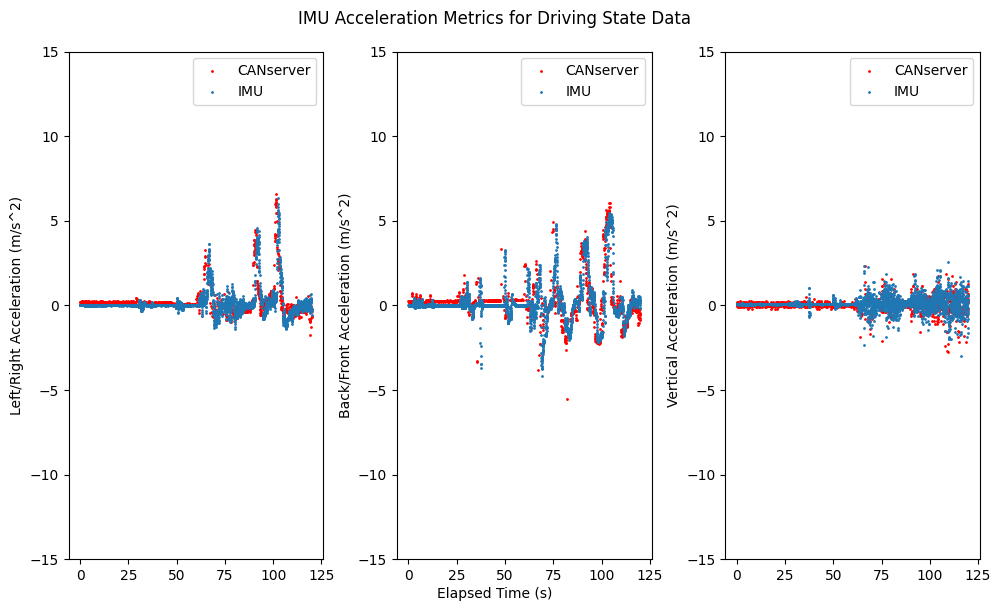

SR=100, gain=0.033: plot number 2


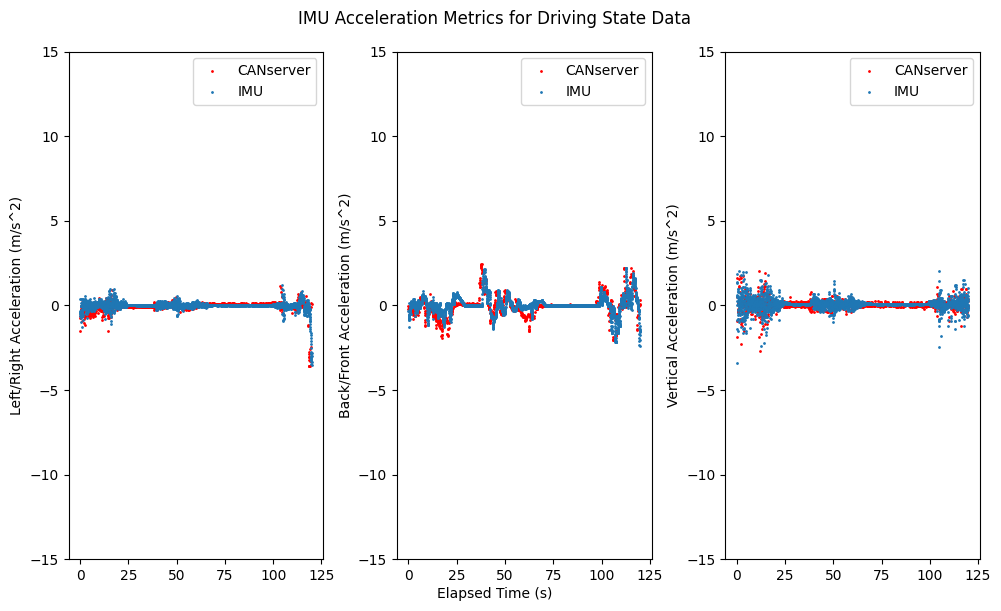

SR=100, gain=0.033: plot number 3


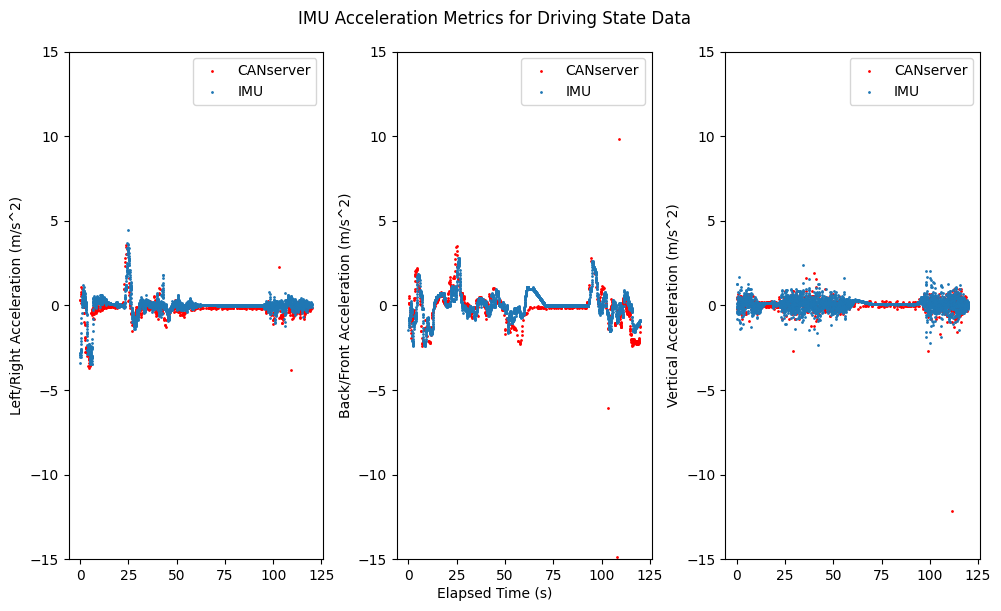

SR=100, gain=0.033: plot number 4


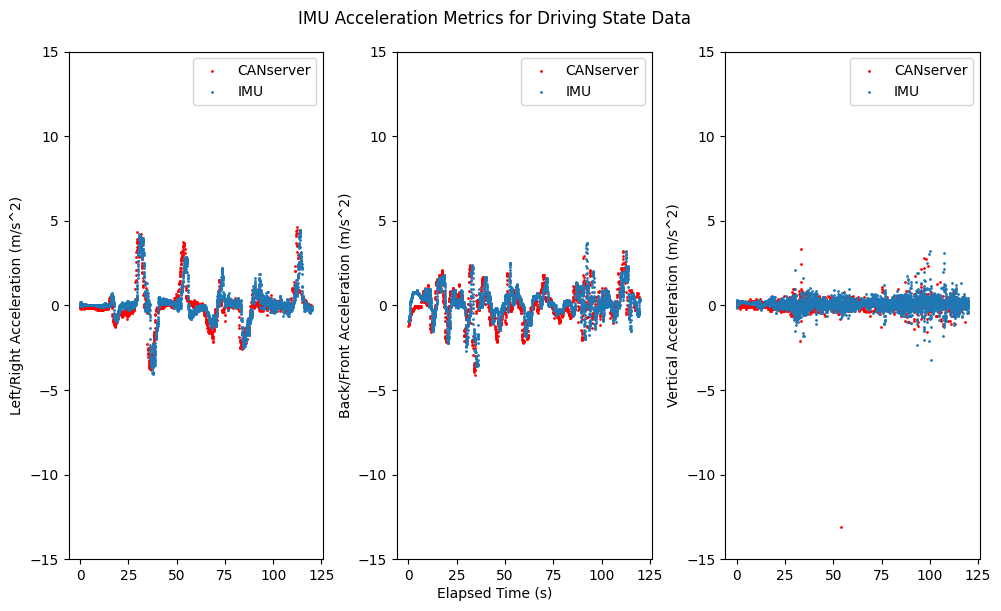

SR=100, gain=0.033: plot number 5


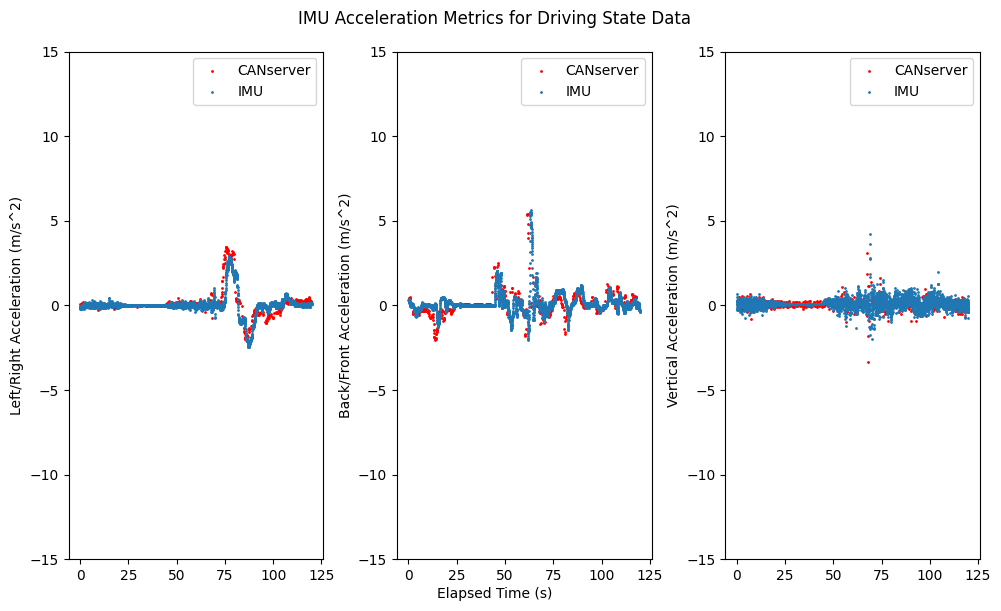

SR=100, gain=0.033: plot number 6


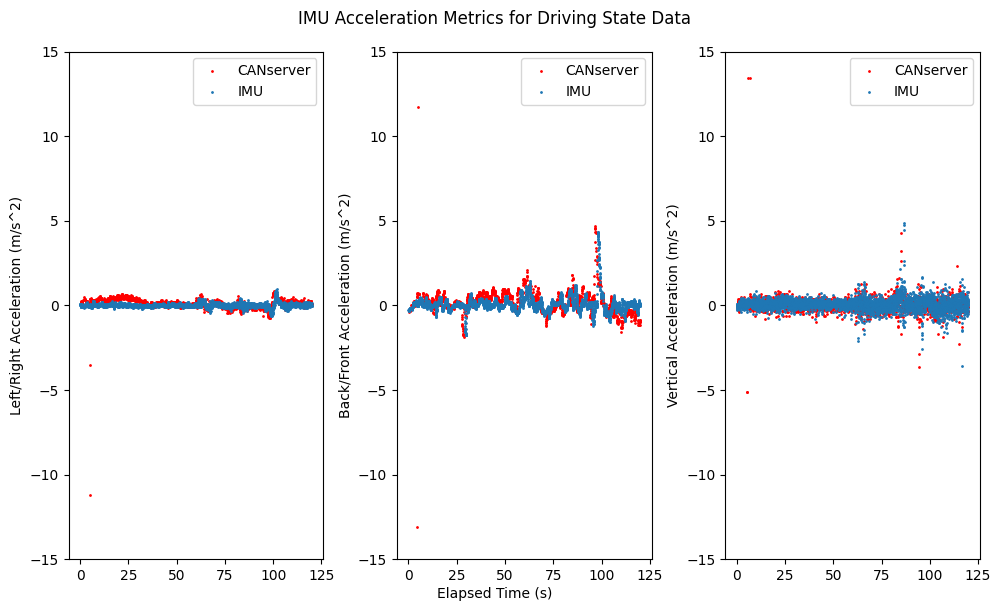

SR=100, gain=0.033: plot number 7


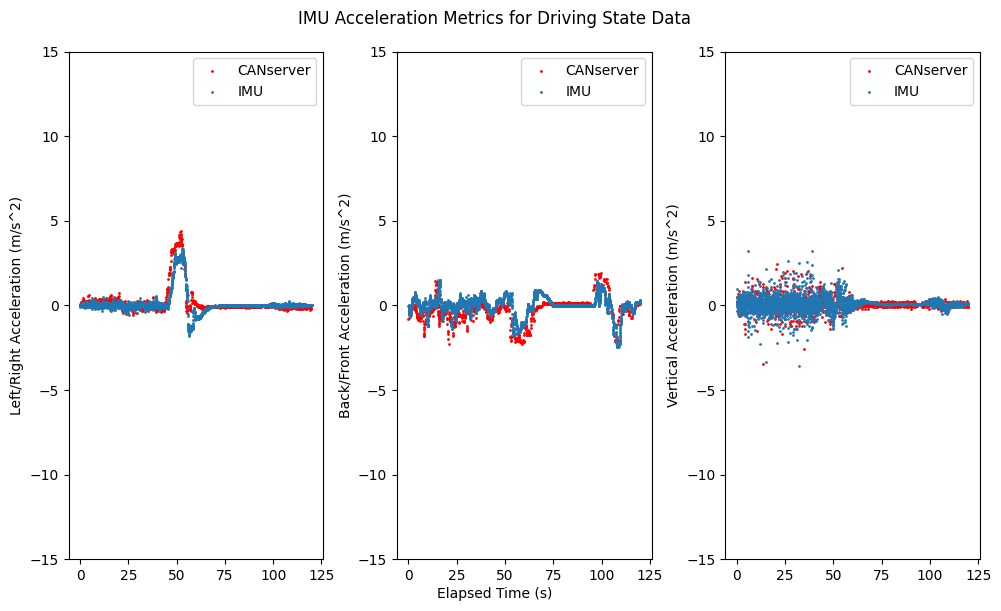

SR=100, gain=0.033: plot number 8


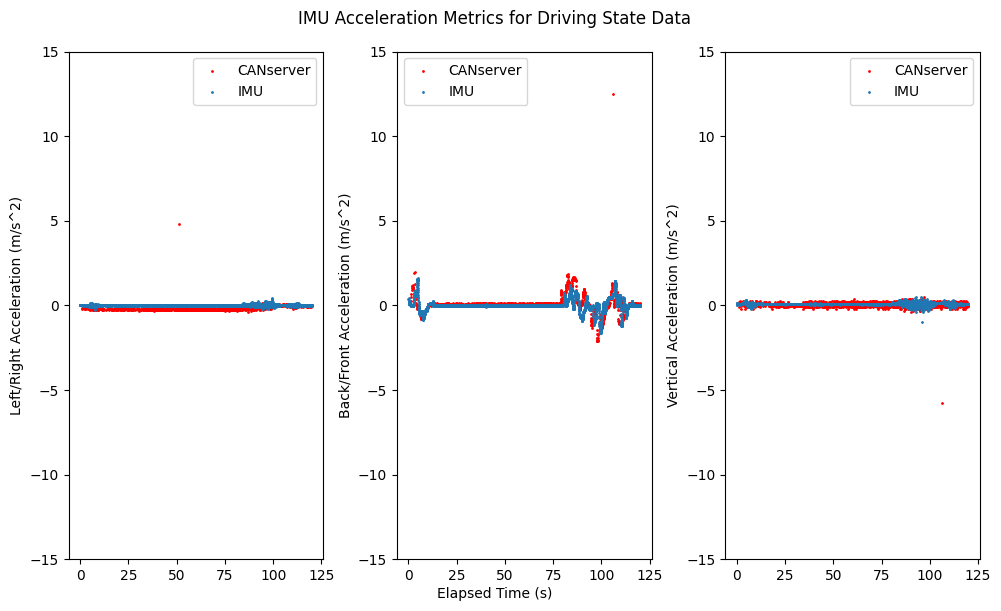

SR=100, gain=0.033: plot number 9


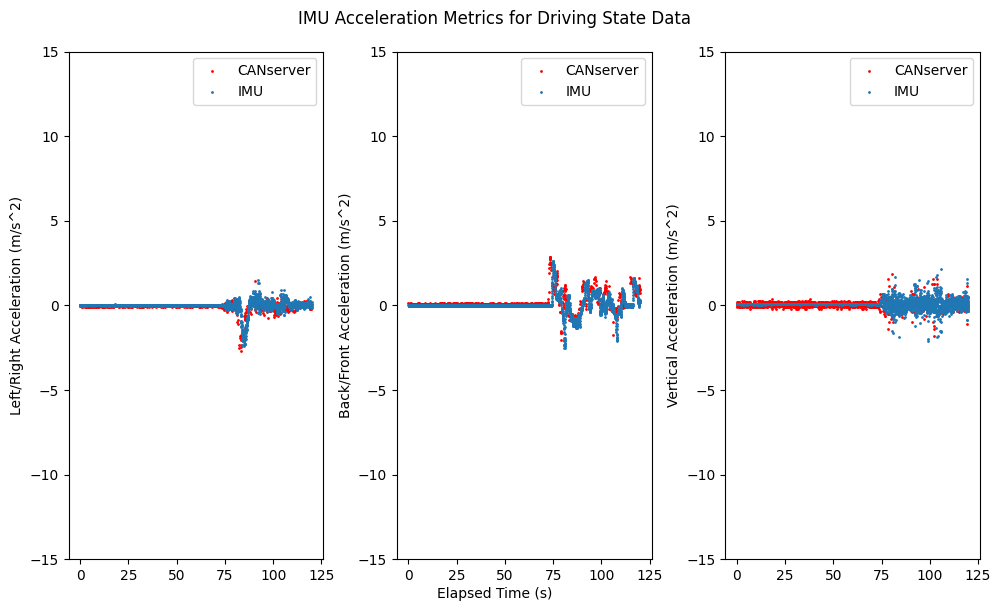

SR=100, gain=0.033: plot number 10


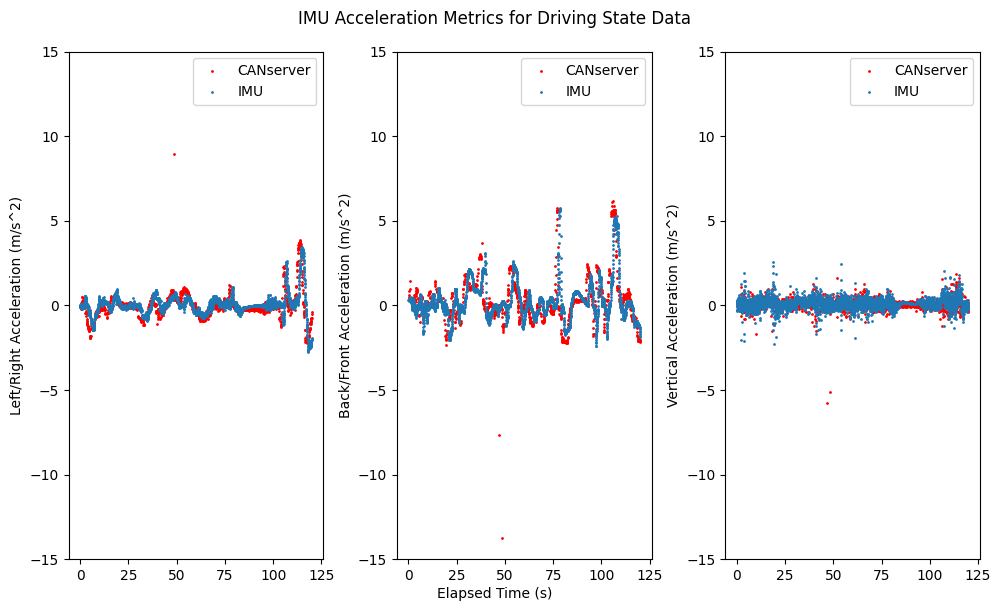

SR=100, gain=0.033: plot number 11


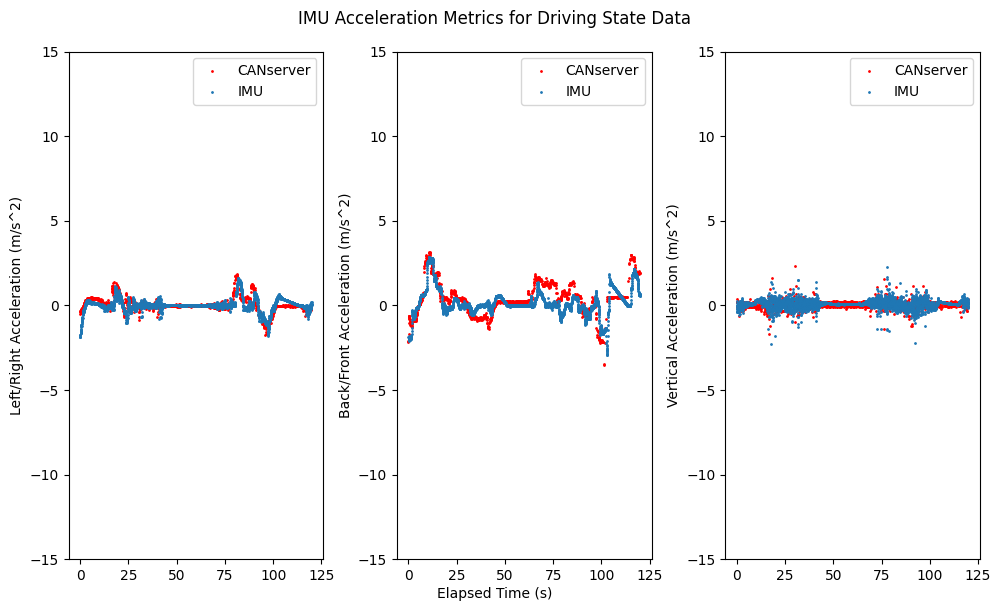

SR=100, gain=0.033: plot number 12


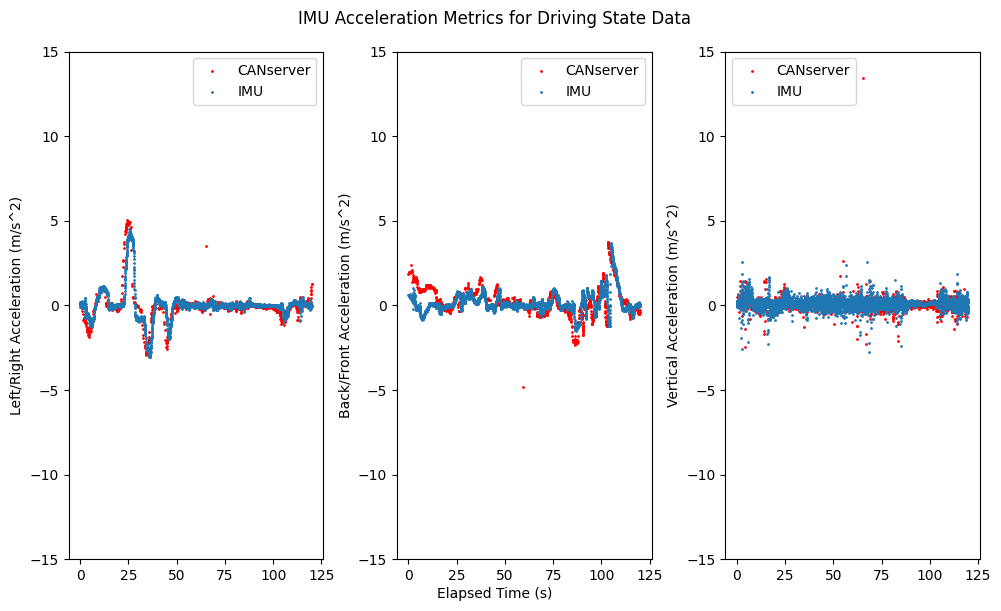

SR=100, gain=0.033: plot number 13


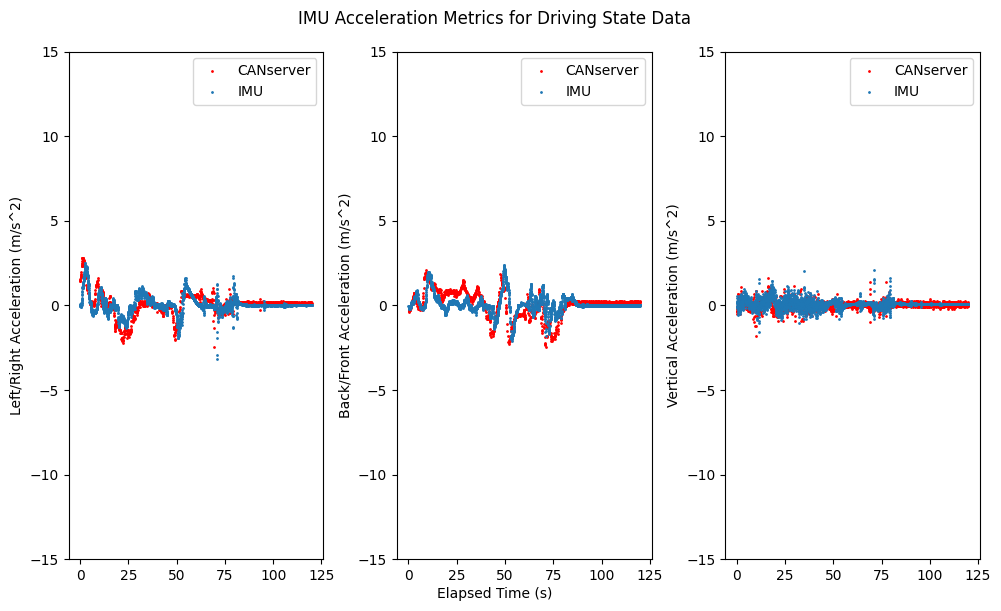

In [28]:
window = 120
count = 0
# can_df = can_df[can_df['bf_acc'].notna()]
# can_df.reset_index(drop=True, inplace=True)

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = raw_df[(raw_df['correct_timestamp'] >= dr_start_time) 
                        & (raw_df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and ((count == 9) or (count == 10))):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0) and count < 30):
            print(f'SR={madgwick_params["SR"]}, gain={madgwick_params["gain"]}: plot number {count}')
            plot_data(dr_motion, can_motion, dr_start_time, 'ac', window)